In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 150)

# Trivial Projector
What happens if we just take a player's cumulative mean fantasy points as the projection?

In [2]:
from dfsmc.simulate import projection

projection_results = projection.get_projections(range(2017,2023), projection.TrivialProjector)
print(projection_results.columns)
print(projection_results.sort_values(by='res_sq', ascending=True).head(100))

Warning! Trivial Projector was not initialized with a week number so it is projecting for all available weeks
         name_display  week_num team_name_abbr pos_game  draftkings_points
3187   Marcedes Lewis        14            JAX       TE                0.0
2404  Aaron Ripkowski        13            GNB       RB                0.0
5287        Lee Smith         1            OAK       TE                0.0
2405  Aaron Ripkowski        14            GNB       RB                0.0
5289        Lee Smith         3            OAK       TE                0.0
2406  Aaron Ripkowski        15            GNB       RB                0.0
5291        Lee Smith         5            OAK       TE                0.0
5292        Lee Smith         6            OAK       TE                0.0
5293        Lee Smith         7            OAK       TE                0.0
2408  Aaron Ripkowski        17            GNB       RB                0.0
4087       Blake Bell         3            MIN       TE          

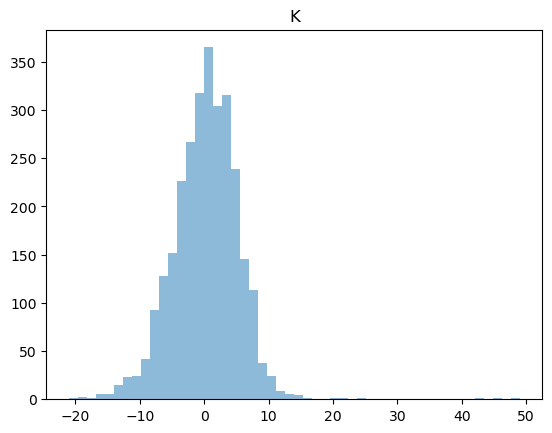

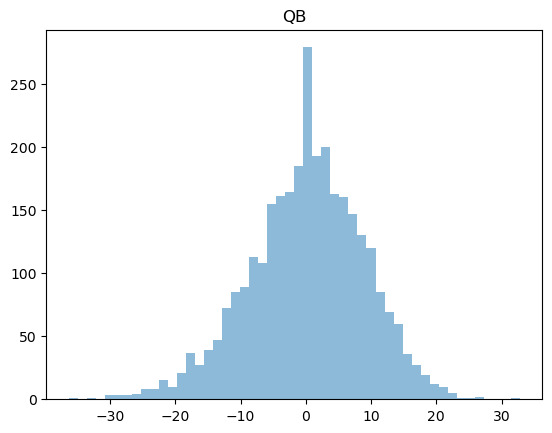

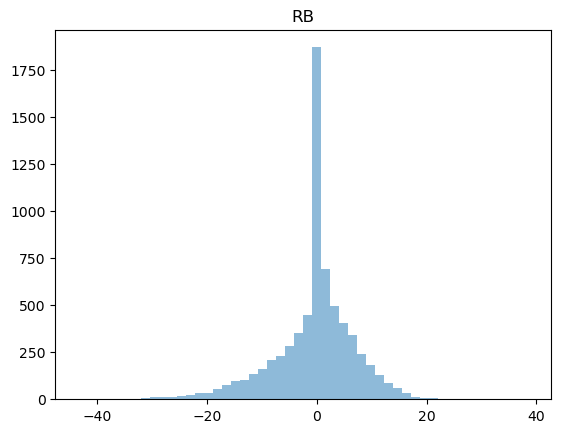

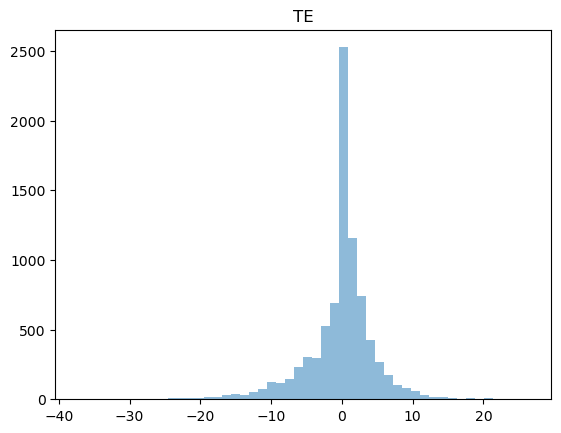

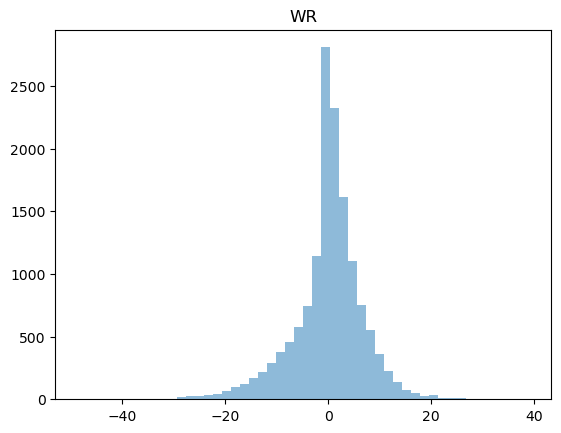

In [3]:
positions = projection_results.groupby('pos_game')

# print(projection_results.loc[positions.groups['QB']])

for pos, df in positions:
    plt.figure()
    plt.hist(df['draftkings_points_predicted'] - df['draftkings_points'], bins=50, alpha=0.5);
    plt.title(pos)